In [1]:
import librosa
import matplotlib
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter

import soundfile as sf

import phast
import abt

from matlab import MatlabData
from utils import bin_over_y
from plotting import plot_pulse_train_stats

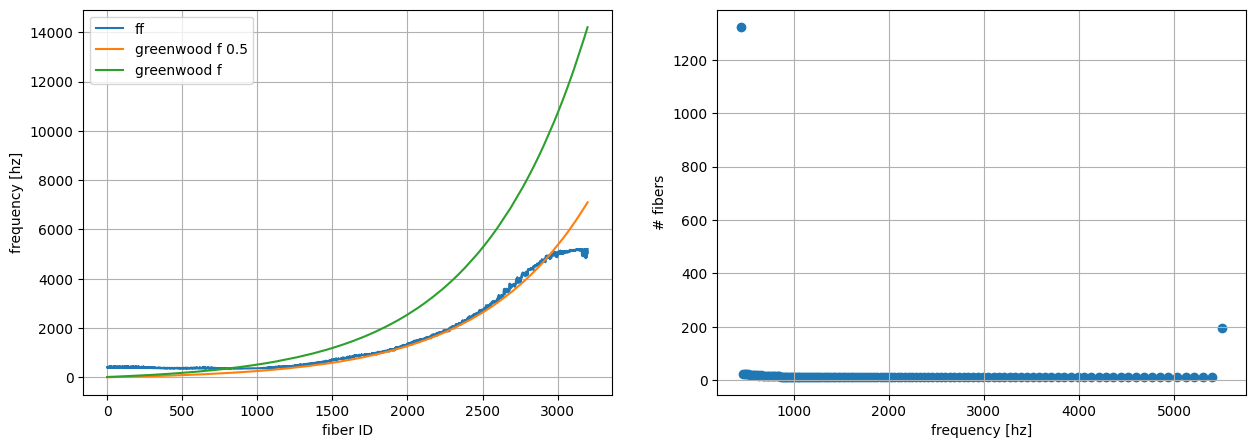

In [4]:
N_MELS = 128
N_FFT = 512
N_HOP = 32

MIN_FREQ = 450
MAX_FREQ = 5500
CS = True
scaling_factor = 1.4
n_trials = 20
BINSIZE = 18e-6 * 2
apply_premph = False
ref_db = 65.

MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 

tp = phast.load_df120()

# # This is incorrect for ACE
channel_freq = phast.scs.ab.defaults.virtual_channel_frequencies(tp.i_det.shape[1], MAX_FREQ + 500)

power = 25
w = (-tp.i_det / tp.i_det.sum(axis=1).reshape(-1, 1)) + (2 / len(channel_freq))
w = np.power(w, power) / np.power(w, power).sum(axis=1).reshape(-1, 1)

fiber_freq = w @ channel_freq
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(fiber_freq, label='ff')
ax1.plot(tp.greenwood_f * .5, label="greenwood f 0.5")
ax1.plot(tp.greenwood_f, label="greenwood f")
ax1.legend()


ax1.set_ylabel("frequency [hz]")
ax1.set_xlabel("fiber ID")
ax1.grid()

fiber_freq = (tp.greenwood_f * .5).clip(0, MAX_FREQ)
unique, counts = np.unique(np.digitize(fiber_freq, MEL_SCALE, True), return_counts=True)

ax2.scatter(MEL_SCALE[unique], counts)
ax2.set_ylabel("# fibers")
ax2.set_xlabel("frequency [hz]")
ax2.grid()

In [111]:
np.median((counts))

np.float64(13.0)

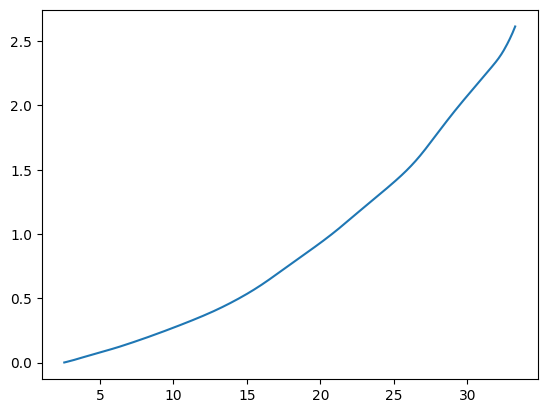

In [ ]:
# tp.electrode.position, tp.electrode.insertion_angle
angles = np.linspace(0, 5 * np.pi, 100)  # Angular positions: 2 full turns
positions = np.linspace(0, 35, 100)     # Arc length in mm (approx cochlea length)

def get_3d(positions, angles, a = 0.1, r_max = 9.0):
    """
    Parameters
    ---------- 
    a: float 
        Decay rate for radius (controls tapering)
    r_max: float
        Initial radius in mm (cochlea base)
    """
    radius = r_max * np.exp(-a * positions)  # Exponentially decreasing radius
    z = positions / max(positions) * 10  # Normalized height (approx 10mm vertical)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    return x, y, z

x, y, z = get_3d(positions, angles)


# Plotting the cochlear spiral
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Cochlear Spiral', color='blue', linewidth=2)


x, y, z = get_3d(tp.electrode.position, np.radians(tp.electrode.insertion_angle))
ax.scatter(x, y, z, label='Cochlear Spiral', color='red')


# Enhance plot aesthetics
ax.set_title('3D Model of the Human Cochlea')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.legend()
# np.c_[tp.position, tp.angle][::-1]

plt.plot(tp.position, tp.angle / 360)


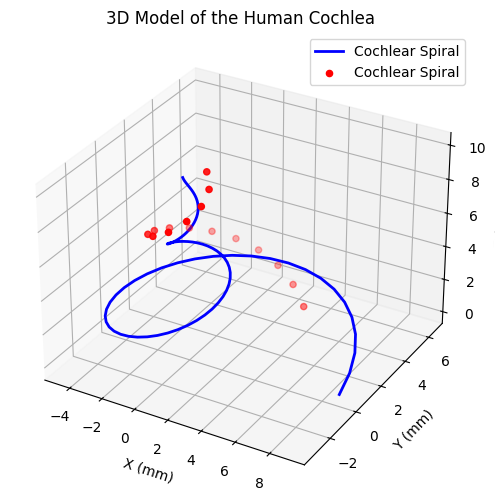

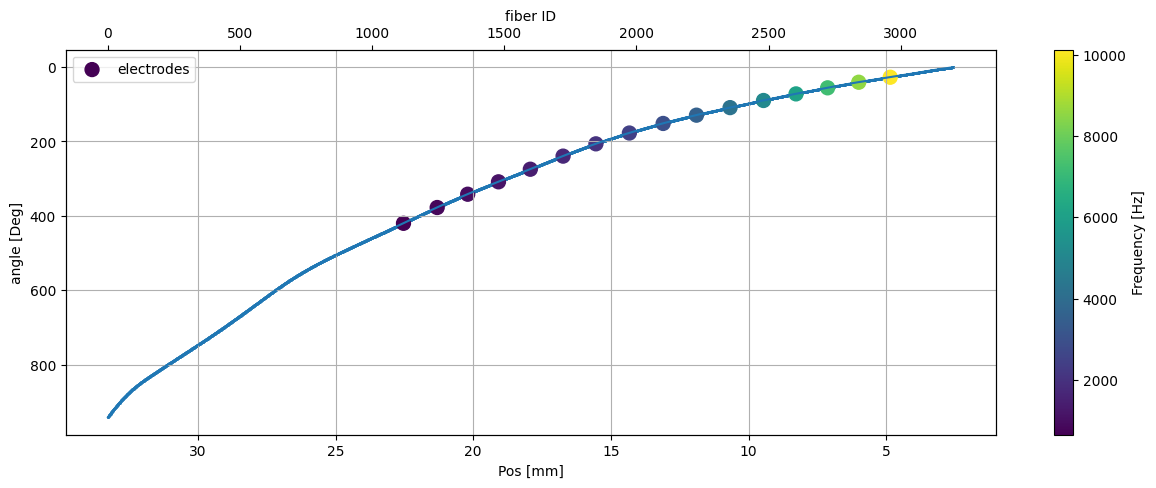

In [108]:
# plt.plot(tp.i_det[:, 0])

plt.figure(figsize=(15, 5))
plt.scatter(tp.position, tp.angle, s=1, alpha=1)
plt.scatter(tp.electrode.position, tp.electrode.insertion_angle, c=tp.electrode.greenwood_f, s=100, label='electrodes')
plt.colorbar(label='Frequency [Hz]')
plt.grid()
plt.legend()
plt.ylabel("angle [Deg]")
plt.xlabel("Pos [mm]")


plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax = plt.gca().twiny()
ax.plot(np.arange(3200), tp.angle)
ax.set_xlabel("fiber ID");

In [126]:
Hu = np.log(np.sqrt(3) --np.sqrt(3))
Hn = .5 * np.log(2 * np.pi * np.e)
Hl = 1 - np.log(2 * np.sqrt(.5))
Hlo = np.log(np.sqrt(3) / np.pi) + 2
Hn, Hu, Hl, Hlo

(np.float64(1.4189385332046727),
 np.float64(1.2424533248940002),
 np.float64(0.6534264097200273),
 np.float64(1.4045762584846546))

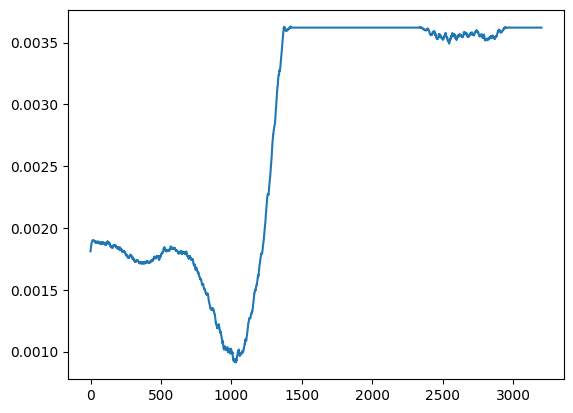

In [142]:
from scipy.signal import savgol_filter
plt.plot(savgol_filter(tp.i_det[:, 0], 51, 3))